In [25]:
import pandas as pd
import datetime
from datetime import datetime as dt_object
from datetime import timedelta
import math
import numpy as np

import pandas as pd
from pandas import Series, DataFrame

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

'2.2.2'

In [27]:
df = pd.read_csv('AMZN.csv').set_index('Date')
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-30,1797.489990,1799.739990,1764.569946,1776.290039,1776.290039,3058700
2019-09-03,1770.000000,1800.800049,1768.000000,1789.839966,1789.839966,3543000
2019-09-04,1805.000000,1807.630005,1796.229980,1800.619995,1800.619995,2324100
2019-09-05,1821.949951,1842.000000,1815.579956,1840.719971,1840.719971,3310800
2019-09-06,1838.219971,1840.650024,1826.400024,1833.510010,1833.510010,2489700


In [28]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [29]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [30]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)

#Lasso Regression
clflasso = Lasso(alpha=0.1)
clflasso.fit(X,y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Simple Linear Regression

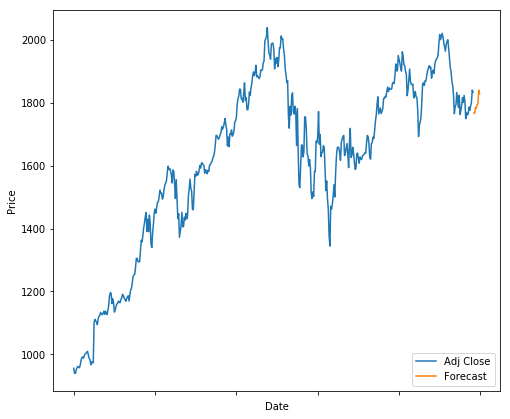

In [31]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

last_date_str = dfreg.iloc[-1].name
last_date = dt_object.strptime(last_date_str, '%Y-%m-%d')
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Lasso Regression

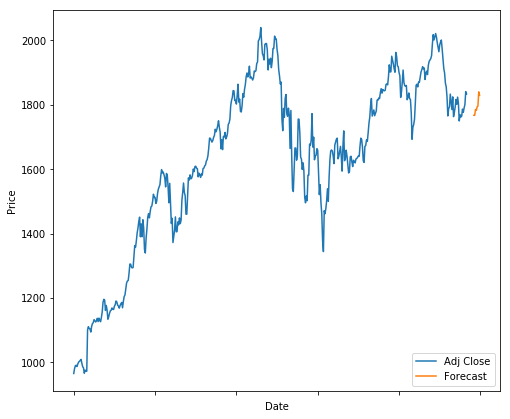

In [32]:
forecast_set = clflasso.predict(X_lately)
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()